In [1]:
import numpy as np
import emcee 
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import stats
# More physical cuts: 
from  galpy.util import bovy_coords
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib inline

In [3]:
data = ascii.read('/Users/iraf1/Downloads/dd') # load data

## Section 1.1 - Quality Cuts
 - Remove NaN values [what age index are the nans]
 - $J_R$/$J_{R_{err}}$ > 20 ( or if this doesn't work -- parallax > 0.5 ) 
 - $J_R$ < 1500 -- looks like some stars have big action values that may be outliers
 - Dist > 0.5 (there seems to be an error with the distance estimate) 




## Section 1.2 - Population Cuts 
 - __Red Giants__: $log(g)$ < 3.8 dex 
 - __Main Sequence__: $log(g)$ > 3.8 dex
 
 


notes: 
 - Jz <1 : will restrict us to the disk 

OR

 - |Z| < 2 : will restrict the search to disk stars


In [5]:
# Define variables from Astropy table 

feh = data['fe_h'] # metalicity 
e_feh = data['e_fe_h']
l, b = data['l'], data['b'] # coordinates in Galactic

jr = data['JR'] # radial action
jr_err = data['JR_err'] # radial action error 

log_g = data['logg_1']
teff = data['teff']
parallax = data['parallax']
log_age = data['log_age']
age = 10**(log_age)
dist = data['dist']
mass = data['mass'] # APOGEE
mu_l , mu_b = data['mu_l'], data['mu_b']
z, kmag, jmag, hmag = data['z'], data['kmag'], data['jmag'], data['hmag']
vr, R = data['vR'], data['R']




# Quality cuts to ensure quality of data : NOTE parallax < 0.5 (2kpc limit!)
qc = np.where((jr/jr_err > 10) & (jr>-2*np.std(jr)) & (jr<2*np.std(jr)) & (age>0.5) & (age != np.ma.core.MaskedConstant()) & (feh != np.ma.core.MaskedConstant()) & (jr != np.ma.core.MaskedConstant()))

feh, e_feh, l, b = feh[qc], e_feh[qc], l[qc], b[qc]
jr, jr_err, log_g, teff, parallax, log_age, dist, mass = jr[qc], jr_err[qc], log_g[qc], teff[qc], parallax[qc], log_age[qc], dist[qc], mass[qc]
mu_l, mu_b, age  = mu_l[qc], mu_b[qc], age[qc]
z, kmag, jmag, hmag = z[qc], kmag[qc], jmag[qc], hmag[qc]
vr,R = vr[qc], R[qc]

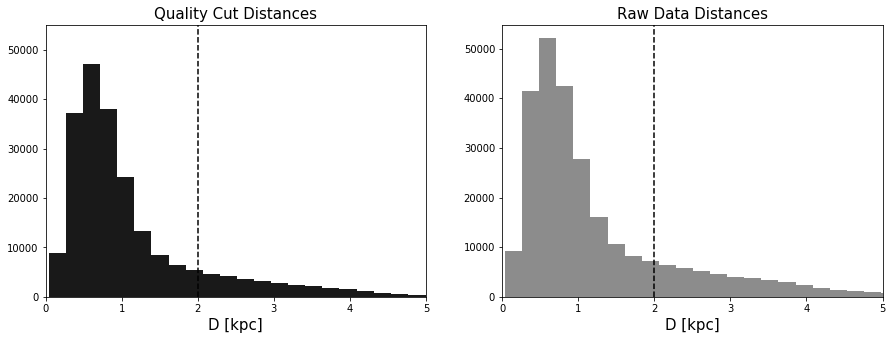

In [6]:
%config InlineBackend.figure_format = 'png'

plt.figure(figsize=(15,11))
plt.subplot(221)
plt.hist(dist, bins=100, normed=False, color='k', alpha=0.9, histtype='stepfilled')
plt.xlim(0,5)
plt.ylim(0,55000)
plt.title('Quality Cut Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')

plt.subplot(222)
plt.hist(data['dist'], bins=100, normed=False, color='gray', alpha=0.9, ls='--', histtype='stepfilled')
plt.xlim(0,5)
plt.title('Raw Data Distances', size=15)
plt.xlabel('D [kpc]', size=15)
plt.axvline(2, color='k', ls='--')

#plt.savefig('f2.pdf', type='pdf',bbox_inches='tight')

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()

Number of stars in MS cut: 157091
Number of stars in RG cut: 62947


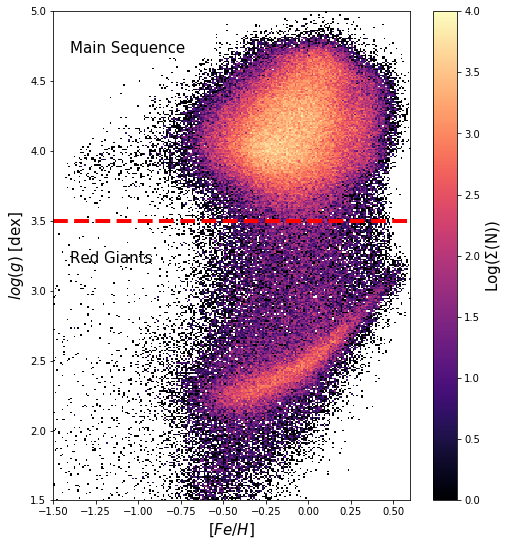

In [7]:
%config InlineBackend.figure_format = 'png'
cut_off = 3.5 # 3.8 sugggested by literatyre
# Apply population cuts
MS = np.where(log_g > cut_off)
RG = np.where(log_g < cut_off)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,9))

g_hist = np.histogram2d(log_g, feh, bins=(np.arange(1.5,5,0.01), np.arange(-1.5, 0.6, 0.01)))

Z = ax.imshow(np.log(g_hist[0]), aspect='auto', origin='lower', interpolation='nearest',
            extent=[-1.5, 0.6, 1.5, 5], cmap='magma', vmin=0, vmax=4)
ax.axhline(cut_off, color='red', ls='--', lw=4)

ax.text(-1.4,3.2, 'Red Giants', size=15, color='k' )
ax.text(-1.4,4.7, 'Main Sequence', size=15, color='k' )

ax.set_xlabel('$[Fe/H]$', size=15)
ax.set_ylabel('$log(g)$ [dex]', size=15)
cbar = fig.colorbar(Z, )#, label='$Log(\Sigma(N))$')
cbar.ax.set_ylabel('Log($\Sigma$(N))', fontsize=15, )

print ("Number of stars in MS cut: %d" %len(MS[0]))
print ("Number of stars in RG cut: %d" %len(RG[0]))




/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()



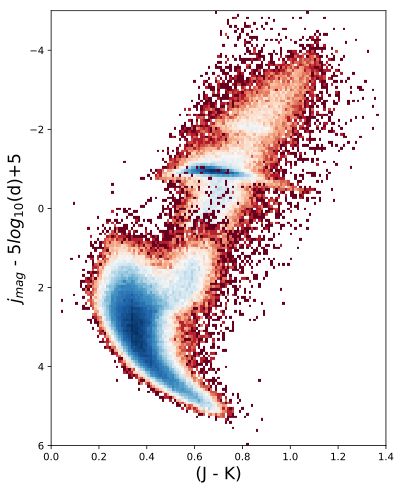

In [8]:
%config InlineBackend.figure_format = 'svg'

color = jmag - kmag
# calculate absolute magniude in jmag 
abs_mag_j = jmag - 5*np.log10(dist*1000) + 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,8))
color_hist = np.histogram2d(abs_mag_j[MS], color[MS],
                           bins=(np.arange(-5, 6, 0.07), np.arange(0, 1.4, 0.01)))
color_hist2 = np.histogram2d(abs_mag_j[RG], color[RG],
                           bins=(np.arange(-5, 6, 0.07), np.arange(0, 1.4, 0.01)))


ax.imshow(np.log(color_hist2[0]), aspect='auto', interpolation='nearest',
          extent=[0, 1.4, 6, -5], cmap='RdBu')
ax.imshow(np.log(color_hist[0]), aspect='auto', interpolation='nearest',
          extent=[0, 1.4, 6, -5], cmap='RdBu')
ax.set_xlabel('(J - K)', size=17)
ax.set_ylabel('$j_{mag}$ - 5$log_{10}$(d)+5', size=17)

plt.savefig('f3.pdf', type='pdf',bbox_inches='tight')


## Gaussian Analysis 

In [107]:
# Let's analyze only the MS 

young_MS = age[MS] < 6 
old_MS = age[MS] > 6

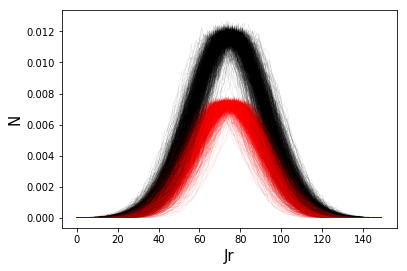

In [108]:
for i in range (0,1000):
    per_young = np.random.normal(np.mean((jr[MS])[young_MS]),np.std((jr[MS])[young_MS]) , len((jr[MS])[young_MS]))
    per_old = np.random.normal(np.mean((jr[MS])[old_MS]),np.std((jr[MS])[old_MS]) , len((jr[MS])[old_MS]))
    
    Z = np.histogram(per_young, bins=150, normed=True)
    Z2 = np.histogram(per_old, bins=150, normed=True)

    plt.plot(Z[0], color='k', alpha=0.5, lw=0.1, label='yong')
    plt.plot(Z2[0], color='red', alpha=0.5, lw=0.1, label='old')
    plt.xlabel('Jr', size=15)
    plt.ylabel('N', size=15)
    
    if i==999:
        plt.savefig('gb.pdf', type='pdf')
        
    
    #plt.plot(Z2[0], color='red')
    #plt.xlim(0,40)

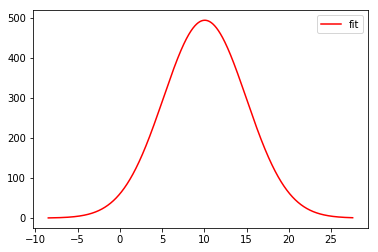

In [55]:
from astropy.modeling import models, fitting

bin_heights, bin_borders = np.histogram(x, bins='auto')
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

t_init = models.Gaussian1D()
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, bin_centers, bin_heights)

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.figure()
#plt.bar(bin_centers, bin_heights, width=bin_widths, label='histogram')
plt.plot(x_interval_for_fit, t(x_interval_for_fit), label='fit', c='red')
plt.legend()

Text(0.5,1,'Red Giants')

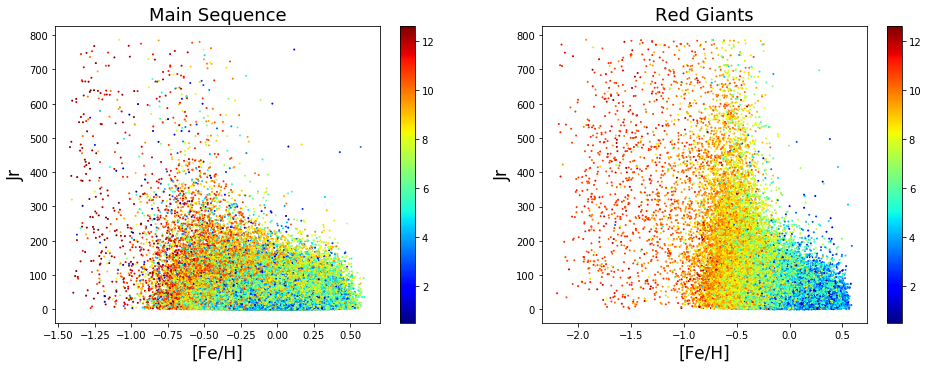

In [9]:
%config InlineBackend.figure_format = 'png'

plt.figure(figsize=(16,12))

plt.subplot(221)
plt.scatter(feh[MS], jr[MS],c=age[MS], s=1, alpha=1, cmap='jet')
#plt.ylim(0,250)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Main Sequence', size=18)

plt.subplot(222)
plt.scatter(feh[RG], jr[RG],c=age[RG], s=1, alpha=1, cmap='jet')
#plt.ylim(0,450)
#plt.xlim(-0.65)
plt.xlabel('[Fe/H]', size=17)
plt.ylabel('Jr', size=17)
plt.colorbar()
plt.title('Red Giants', size=18)



In [10]:
df_ms  = stats.binned_statistic_2d(jr[MS], feh[MS], age[MS], statistic='median',
                                   bins=(np.arange(0, 600, 25), np.arange(-1, 0.6, 0.1)))

df_rg  = stats.binned_statistic_2d(jr[RG], feh[RG], age[RG], statistic='median',
                              bins=(np.arange(0, 800, 25), np.arange(-1.5, 0.6, 0.1)))

Text(0,0.5,'$J_R$')

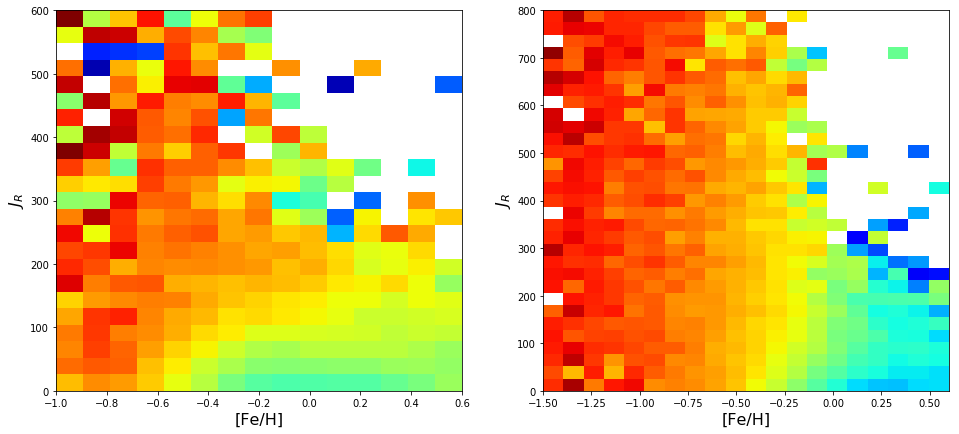

In [11]:
%config InlineBackend.figure_format = 'png'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

ax2 = ax[0].imshow((df_ms[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1, 0.6, 0, 600])

ax[0].set_xlabel('[Fe/H]', size=16)
ax[0].set_ylabel('$J_R$', size=16)


ax1 =  ax[1].imshow((df_rg[0]), aspect='auto', origin='lower', cmap='jet',
          vmin=0, vmax=12, extent=[-1.5, 0.6, 0, 800])
ax[1].set_xlabel('[Fe/H]', size=16)
ax[1].set_ylabel('$J_R$', size=16)



/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Text(0,0.5,'Age')

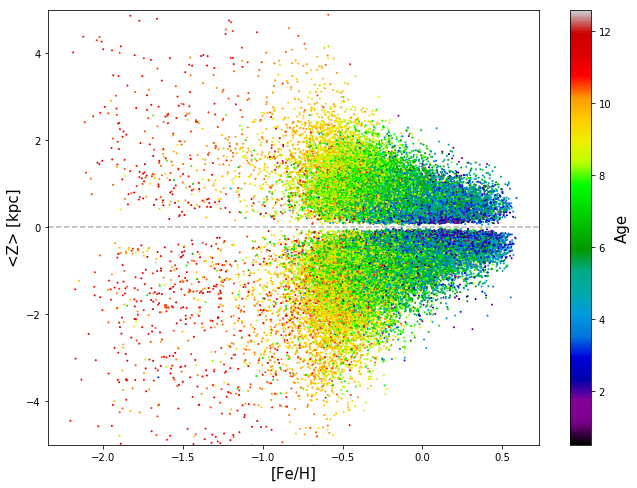

In [12]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(11,8))
Z2 = ax.scatter(feh[RG], z[RG], c=age[RG], cmap='spectral', s=1)
ax.set_ylim(-5,5)
ax.axhline(0, color='k', ls='--', alpha=0.3)
ax.set_ylabel('<Z> [kpc]', size=15)
ax.set_xlabel('[Fe/H]', size=15)
cbare = fig.colorbar(Z2)
cbare.ax.set_ylabel('Age', size=15)



/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'[Fe/H]')

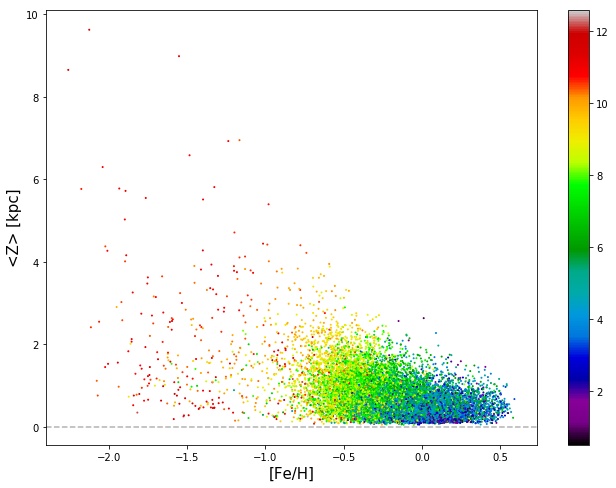

In [13]:
plt.figure(figsize=(11,8))
plt.scatter((feh[RG])[z[RG]>0], (z[RG])[z[RG]>0], c=(age[RG])[z[RG]>0], cmap='spectral', s=1)
plt.colorbar()
#plt.ylim(-5,5)
plt.axhline(0, color='k', ls='--', alpha=0.3)
plt.ylabel('<Z> [kpc]', size=15)
plt.xlabel('[Fe/H]', size=15)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


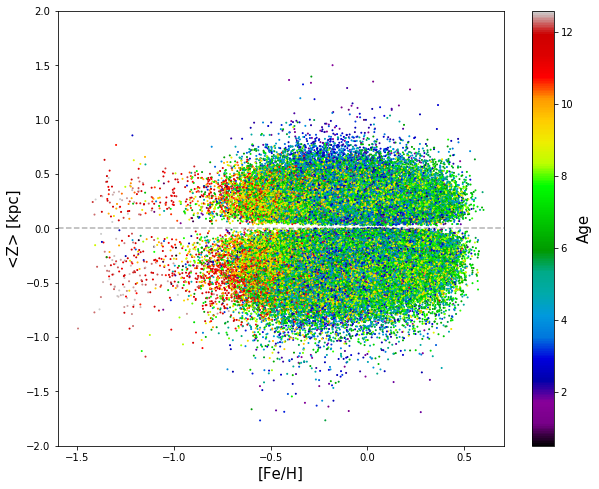

In [55]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
z3 = ax.scatter(feh[MS], z[MS], c=age[MS], cmap='spectral', s=1)

ax.set_ylim(-2,2)
ax.axhline(0, color='k', ls='--', alpha=0.3)
ax.set_ylabel('<Z> [kpc]', size=15)
ax.set_xlabel('[Fe/H]', size=15)
cbb = fig.colorbar(z3)
cbb.ax.set_ylabel('Age', size=15)




In [57]:
xyz = bovy_coords.lbd_to_XYZ(l, b, dist, ) # XYZ projections
vxyz = bovy_coords.vrpmllpmbb_to_vxvyvz(vr, mu_l, mu_b, l, b, dist) # vxvyvz


# Define variables
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
vx, vy, vz = vxyz[:,0], vxyz[:,1], vxyz[:,2]

In [58]:
# Let's project all dimensions in X,Y with mean <Z> 


/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



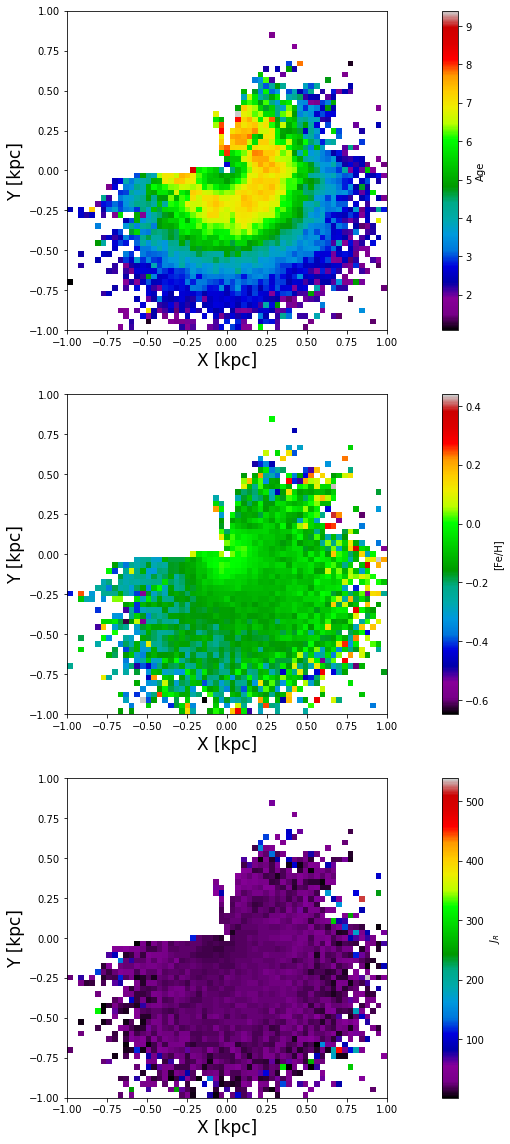

In [140]:
# Let's project <x,y> as function of age, feh, jr: RG : MS 
phy_1 = stats.binned_statistic_2d(y[MS] ,x[MS] , age[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))
phy_2 = stats.binned_statistic_2d(y[MS] ,x[MS] , feh[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))
phy_3 = stats.binned_statistic_2d(y[MS] ,x[MS] , jr[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

Zz = ax[0].imshow(phy_1[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-1,1,-1,1])
ax[0].set_xlabel('X [kpc]', size=17)
ax[0].set_ylabel('Y [kpc]', size=17)
cey = fig.colorbar(Zz, ax=ax[0],orientation='vertical',label='Age')

Zz2 = ax[1].imshow(phy_2[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-1,1,-1,1])
ax[1].set_xlabel('X [kpc]', size=17)
ax[1].set_ylabel('Y [kpc]', size=17)
fig.colorbar(Zz2, ax=ax[1],orientation='vertical', label='[Fe/H]')

Zz3 = ax[2].imshow(phy_3[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-1,1,-1,1])
ax[2].set_xlabel('X [kpc]', size=17)
ax[2].set_ylabel('Y [kpc]', size=17)
fig.colorbar(Zz3, ax=ax[2],orientation='vertical', label='$J_R$')




/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



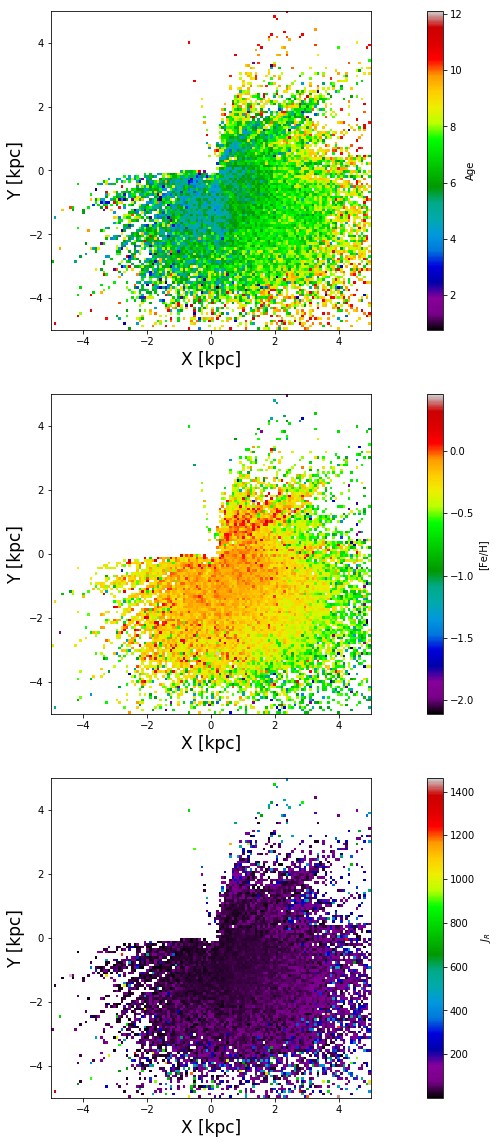

In [141]:
# Let's project <x,y> as function of age, feh, jr: RG: RED GIANTS 
lim = 5
Phy_1 = stats.binned_statistic_2d(y[RG] ,x[RG] , age[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))
Phy_2 = stats.binned_statistic_2d(y[RG] ,x[RG] , feh[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))
Phy_3 = stats.binned_statistic_2d(y[RG] ,x[RG] , jr[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

ZZz = ax[0].imshow(Phy_1[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim])
ax[0].set_xlabel('X [kpc]', size=17)
ax[0].set_ylabel('Y [kpc]', size=17)
fig.colorbar(ZZz, ax=ax[0],orientation='vertical', label='Age')

ZZz2 = ax[1].imshow(Phy_2[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim])
ax[1].set_xlabel('X [kpc]', size=17)
ax[1].set_ylabel('Y [kpc]', size=17)
fig.colorbar(ZZz2, ax=ax[1],orientation='vertical', label='[Fe/H]')

ZZz3 = ax[2].imshow(Phy_3[0], cmap='spectral', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim])
ax[2].set_xlabel('X [kpc]', size=17)
ax[2].set_ylabel('Y [kpc]', size=17)
fig.colorbar(ZZz3, ax=ax[2],orientation='vertical', label='$J_R$')



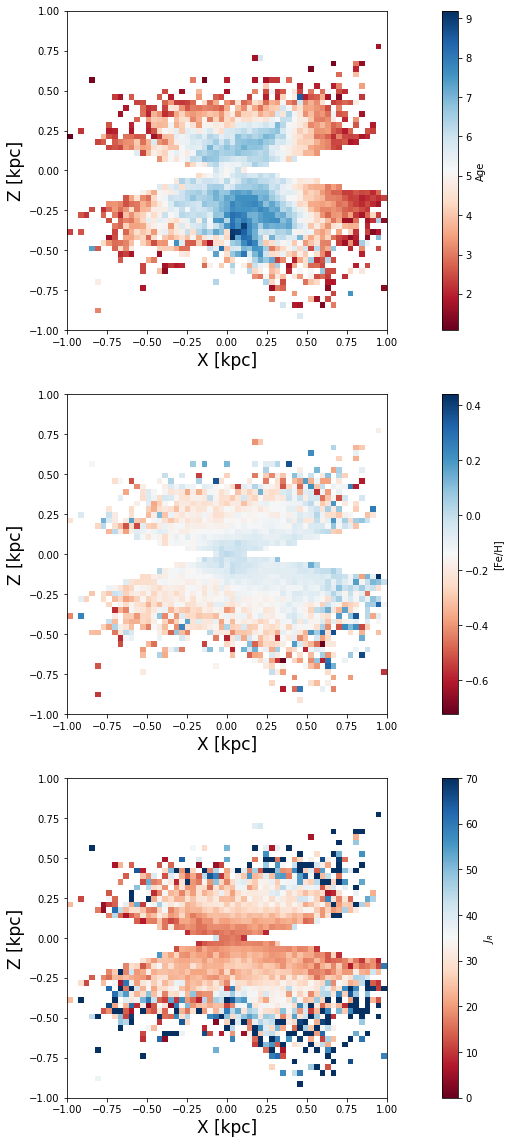

In [68]:
# Let's project <x,z> as function of age, feh, jr: RG : MS 
pz_1 = stats.binned_statistic_2d(z[MS] ,x[MS] , age[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))
pz_2 = stats.binned_statistic_2d(z[MS] ,x[MS] , feh[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))
pz_3 = stats.binned_statistic_2d(z[MS] ,x[MS] , jr[MS], statistic='median',
                                 bins=(np.arange(-2, 2, 0.07), np.arange(-2, 2, 0.07)))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

Zz = ax[0].imshow(pz_1[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-1,1,-1,1])
ax[0].set_xlabel('X [kpc]', size=17)
ax[0].set_ylabel('Z [kpc]', size=17)
cey = fig.colorbar(Zz, ax=ax[0],orientation='vertical',label='Age')

Zz2 = ax[1].imshow(pz_2[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-1,1,-1,1])
ax[1].set_xlabel('X [kpc]', size=17)
ax[1].set_ylabel('Z [kpc]', size=17)
fig.colorbar(Zz2, ax=ax[1],orientation='vertical', label='[Fe/H]')

Zz3 = ax[2].imshow(pz_3[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-1,1,-1,1], vmin=0, vmax=70)
ax[2].set_xlabel('X [kpc]', size=17)
ax[2].set_ylabel('Z [kpc]', size=17)
fig.colorbar(Zz3, ax=ax[2],orientation='vertical', label='$J_R$')


plt.savefig('pp2.pdf', type='pdf')


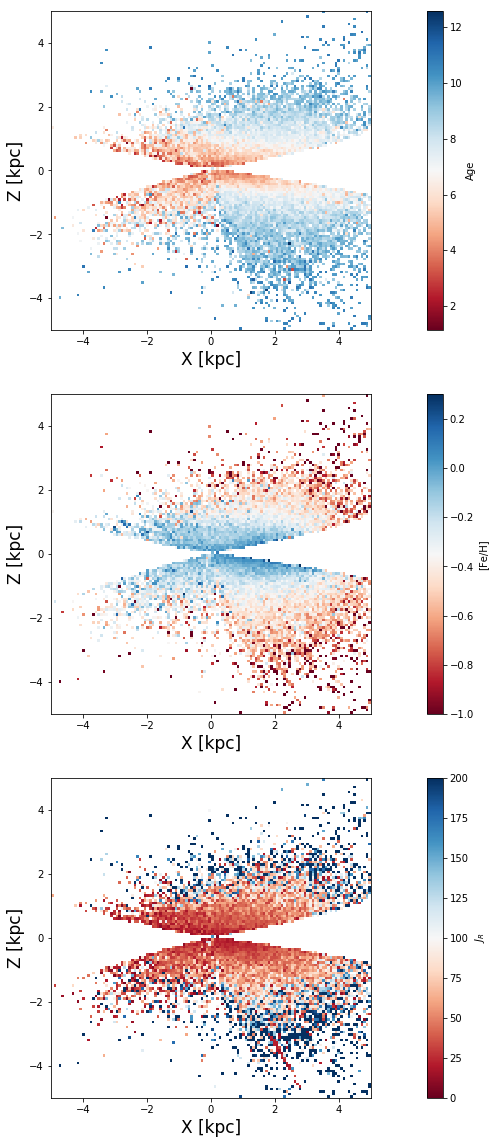

In [63]:
# Let's project <x,y> as function of age, feh, jr: RG: RED GIANTS 
lim = 5
PZ_1 = stats.binned_statistic_2d(z[RG] ,x[RG] , age[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))
PZ_2 = stats.binned_statistic_2d(z[RG] ,x[RG] , feh[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))
PZ_3 = stats.binned_statistic_2d(z[RG] ,x[RG] , jr[RG], statistic='median',
                                 bins=(np.arange(-lim, lim, 0.08), np.arange(-lim, lim, 0.08)))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

ZZz = ax[0].imshow(PZ_1[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim])
ax[0].set_xlabel('X [kpc]', size=17)
ax[0].set_ylabel('Z [kpc]', size=17)
fig.colorbar(ZZz, ax=ax[0],orientation='vertical', label='Age')

ZZz2 = ax[1].imshow(PZ_2[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim],
                   vmin=-1, vmax=0.3)
ax[1].set_xlabel('X [kpc]', size=17)
ax[1].set_ylabel('Z [kpc]', size=17)
fig.colorbar(ZZz2, ax=ax[1],orientation='vertical', label='[Fe/H]')

ZZz3 = ax[2].imshow(PZ_3[0], cmap='RdBu', origin='lower', interpolation='nearest', extent=[-lim,lim,-lim,lim], vmin=0, vmax=200)
ax[2].set_xlabel('X [kpc]', size=17)
ax[2].set_ylabel('Z [kpc]', size=17)
fig.colorbar(ZZz3, ax=ax[2],orientation='vertical', label='$J_R$')


plt.savefig('pp1.pdf', type='pdf') # RG 






In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[MS], y[MS], z[MS], c=age[MS], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieA%d.png" %ii, bbox_inches='tight')

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


KeyboardInterrupt: 

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


KeyboardInterrupt: 

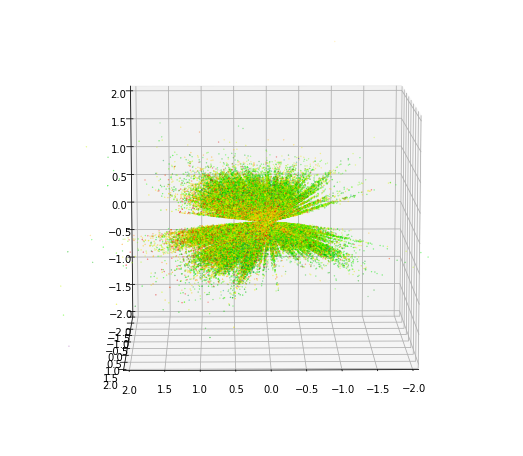

In [10]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[MS], y[MS], z[MS], c=feh[MS], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieF%d.png" %ii, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[MS], y[MS], z[MS], c=jr[MS], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieJ%d.png" %ii, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[RG], y[RG], z[RG], c=age[RG], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieAA%d.png" %ii, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[RG], y[RG], z[RG], c=age[RG], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieFF%d.png" %ii, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[RG], y[RG], z[RG], c=age[RG], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieJJ%d.png" %ii, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[RG], y[RG], z[RG], c=feh[RG], s=0.1, cmap='spectral')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

for ii in range(0,360,1):
    print (ii)
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movieFF%d.png" %ii, bbox_inches='tight')